# Packages

In [2]:
import os
import json
import time
from pathlib import Path
from datetime import datetime
import ast
import math
import tqdm

import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import random

import tensorflow as tf
from tensorflow import keras

from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import Adam
from keras.layers import Input

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve
import sklearn.isotonic as sk_i
from sklearn.model_selection import StratifiedKFold

# Loading Data

In [4]:
PROJECT_ROOT = Path.cwd().resolve().parent
DATA_DIR = PROJECT_ROOT / "data"
PROCESSED_DIR = DATA_DIR / "processed"
RAW_DIR = DATA_DIR / "raw"

In [5]:
football_df = pd.read_pickle(PROCESSED_DIR / "football_processed.pickle")
football_model_df = pd.read_pickle(PROCESSED_DIR / "football_model_processed.pickle")

# Looking at data

In [7]:
football_model_df.columns

Index(['under_pressure', 'shot_open_goal', 'shot_first_time',
       'shot_one_on_one', 'shot_outcome_encoded', 'player_x', 'player_y',
       'distance_from_goal_center', 'distance_from_goal_left_post',
       'distance_from_goal_right_post', 'body_part_head', 'body_part_other',
       'body_part_foot', 'shot_technique_backheel',
       'shot_technique_diving_header', 'shot_technique_half_volley',
       'shot_technique_lob', 'shot_technique_normal',
       'shot_technique_overhead_kick', 'shot_technique_volley',
       'play_pattern_from_corner', 'play_pattern_from_counter',
       'play_pattern_from_free_kick', 'play_pattern_from_goal_kick',
       'play_pattern_from_keeper', 'play_pattern_from_kick_off',
       'play_pattern_from_throw_in', 'play_pattern_other',
       'play_pattern_regular_play', 'shot_type_free_kick',
       'shot_type_open_play', 'goalkeeper_x', 'goalkeeper_y',
       'gk_distance_from_goal_center', 'gk_distance_from_goal_left_post',
       'gk_distance_from_goa

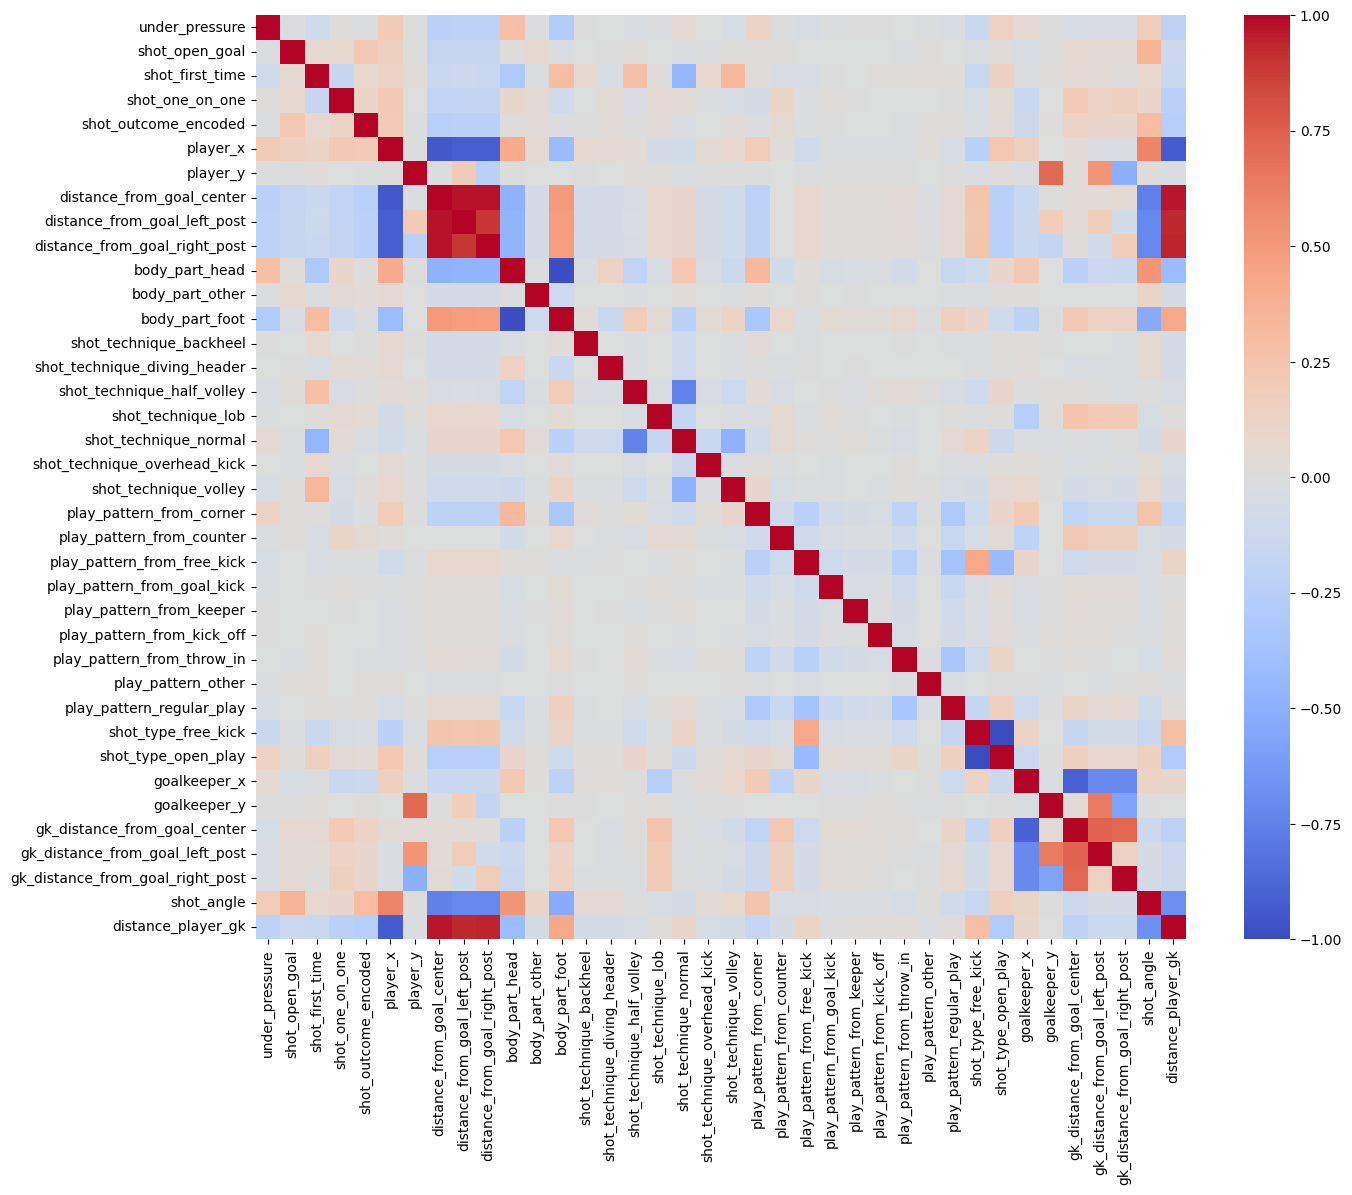

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 12))  # increase figure size
sns.heatmap(football_model_df.corr(), annot=False, cmap="coolwarm", center=0)
plt.show()

# Preparing Data for training

Splitting train and test data

In [9]:
X = football_model_df.drop("shot_outcome_encoded", axis = 1)
y = football_model_df["shot_outcome_encoded"]

In [11]:
# setting a seed
seed = 123

random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

# splitting the data
train_x, test_x , train_y, test_y = train_test_split(
    X, y,
    test_size = 0.25,
    random_state= 123,
    stratify=y
)

In [12]:
train_x, train_y = tf.convert_to_tensor(train_x, dtype=tf.float32), tf.convert_to_tensor(train_y, dtype=tf.float32)
test_x, test_y = tf.convert_to_tensor(test_x, dtype=tf.float32), tf.convert_to_tensor(test_y, dtype=tf.float32)

# Building the model

## Defining Functions

In [13]:
def build_model(hl: int = 1, nodes: int = 32, activation: str = 'relu', epochs: int = 5, batches: int = 100):

    # initiating model
    model = keras.Sequential()

    # adding input layer
    model.add(Input(shape=(37,), name = "Input_Layer")) # 37 input columns

    # adding hidden layers
    for i in range(hl):
        model.add(Dense(units = nodes, activation = activation, name = f"HL_{i+1}"))

    # add output layer
    model.add(Dense(units = 1, activation = "sigmoid", name = "Output_Layer"))

    # compile model
    model.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["binary_accuracy", tf.keras.metrics.AUC(name='auc')])

    return model

In [14]:
def train_and_evaluate_model(hl: int = 1,
                             nodes: int = 32,
                             activation: str = 'relu',
                             epochs: int = 5,
                             batches: int = 100,
                             train_x = train_x,
                             train_y = train_y,
                             test_x = test_x,
                             test_y = test_y
                             ):

    model = build_model(hl, nodes, activation, epochs, batches)

    # training the model
    history = model.fit(
        train_x,
        train_y,
        epochs = epochs,
        batch_size = batches,
        validation_data = (test_x, test_y),
        verbose = 1
    )

    # getting accuracies
    eval_accuracies = model.evaluate(test_x, test_y)

    return model, history, eval_accuracies

In [15]:
def k_fold_cross_validation(hl: int = 1,
                            nodes: int = 32,
                            activation: str = 'relu',
                            epochs: int = 5,
                            batches: int = 100,
                            k: int = 5,
                            train_x = train_x,
                            train_y = train_y
                            ):

    # set seed
    seed = 123
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

    # Initialize StratifiedKFold
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=seed)

    # Create empty lists to store metrics from each fold
    fold_losses = []
    fold_accuracies = []
    fold_aucs = []

    # Convert train_x and train_y to numpy for StratifiedKFold
    train_x_np = train_x.numpy()
    train_y_np = train_y.numpy()

    # Loop through the splits
    for fold, (train_index, val_index) in enumerate(skf.split(train_x_np, train_y_np)):
        print(f"\n--- Starting Fold {fold+1}/{k} ---")

        # Create training and validation datasets for the current fold
        fold_train_x = train_x_np[train_index]
        fold_train_y = train_y_np[train_index]
        fold_val_x = train_x_np[val_index]
        fold_val_y = train_y_np[val_index]

        # Convert to TensorFlow tensors
        fold_train_x = tf.convert_to_tensor(fold_train_x, dtype=tf.float32)
        fold_train_y = tf.convert_to_tensor(fold_train_y, dtype=tf.float32)
        fold_val_x = tf.convert_to_tensor(fold_val_x, dtype=tf.float32)
        fold_val_y = tf.convert_to_tensor(fold_val_y, dtype=tf.float32)

        # Train and evaluate the model for the current fold
        model, history, eval_accuracies = train_and_evaluate_model(
            hl=hl,
            nodes=nodes,
            activation=activation,
            epochs=epochs,
            batches=batches,
            train_x=fold_train_x,
            train_y=fold_train_y,
            test_x=fold_val_x,
            test_y=fold_val_y
        )

        # eval_accuracies contains [loss, binary_accuracy, auc]
        fold_losses.append(eval_accuracies[0])
        fold_accuracies.append(eval_accuracies[1])
        fold_aucs.append(eval_accuracies[2])

        print(f"Fold {fold+1} Metrics: Loss = {eval_accuracies[0]:.4f}, Accuracy = {eval_accuracies[1]:.4f}, AUC = {eval_accuracies[2]:.4f}")

    print("\n--- K-Fold Cross-Validation Complete ---")
    print(f"Average Loss: {np.mean(fold_losses):.4f}")
    print(f"Average Accuracy: {np.mean(fold_accuracies):.4f}")
    print(f"Average AUC: {np.mean(fold_aucs):.4f}")

    return fold_losses, fold_accuracies, fold_aucs, model

# Looking at Training results

## Training the models

In [15]:
# setting a seed
seed = 123

random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

# defining options
hidden_layer_configs = [1,2,3,4,5]
activation_config = ['relu', 'sigmoid', 'tanh']
node_configs = [16, 32, 64, 128, 256]

comparison_list = []
comparison_df_new = pd.DataFrame()

# training models
with tf.device('/GPU:0'):
    for activation in tqdm.tqdm(activation_config):
        for hl in hidden_layer_configs:
            for nodes in node_configs:
                print("-"*40)
                print(f"Performing training for: {activation, hl, nodes}")
                print("-"*40)
                # train model
                fold_loss, fold_accuracies, fold_aucs, _ = k_fold_cross_validation(hl=hl, nodes=nodes, activation=activation, epochs = 10)
                # store output
                comparison_list.append((activation, hl, nodes, fold_loss, fold_accuracies, fold_aucs))

comparison_df = pd.DataFrame(comparison_list)
comparison_df.to_csv("/content/drive/MyDrive/Data Analytics/Assignments/Group Project/model_comparison_five_fold_strat.csv", index = False)

  0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------
Performing training for: ('relu', 1, 16)
----------------------------------------

--- Starting Fold 1/5 ---
Epoch 1/10
272/272 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - auc: 0.6250 - binary_accuracy: 0.7419 - loss: 2.9174 - val_auc: 0.7233 - val_binary_accuracy: 0.9023 - val_loss: 0.2893
Epoch 2/10
272/272 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - auc: 0.7684 - binary_accuracy: 0.8985 - loss: 0.2768 - val_auc: 0.7710 - val_binary_accuracy: 0.9034 - val_loss: 0.2737
Epoch 3/10
272/272 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - auc: 0.7898 - binary_accuracy: 0.9029 - loss: 0.2642 - val_auc: 0.7802 - val_binary_accuracy: 0.9062 - val_loss: 0.2763
Epoch 4/10
272/272 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - auc: 0.7945 - binary_accuracy: 0.9060 - loss: 0.2605 - val_auc: 0.7825 - val_binary_accuracy: 0.9068 - val_loss: 0.2724
Epoch 5/10
272/272 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - auc: 0.7973 - binary_accuracy: 0.9079 - loss: 0.2581 - val_auc: 0.7835 - val_binary_accuracy: 0.907

 33%|███▎      | 1/3 [27:29<54:58, 1649.24s/it]

Fold 5 Metrics: Loss = 0.2592, Accuracy = 0.9110, AUC = 0.8105

--- K-Fold Cross-Validation Complete ---
Average Loss: 0.2597
Average Accuracy: 0.9092
Average AUC: 0.8063
----------------------------------------
Performing training for: ('sigmoid', 1, 16)
----------------------------------------

--- Starting Fold 1/5 ---
Epoch 1/10
272/272 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - auc: 0.5407 - binary_accuracy: 0.8881 - loss: 0.4453 - val_auc: 0.7252 - val_binary_accuracy: 0.9044 - val_loss: 0.2942
Epoch 2/10
272/272 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - auc: 0.7504 - binary_accuracy: 0.9069 - loss: 0.2838 - val_auc: 0.7611 - val_binary_accuracy: 0.9044 - val_loss: 0.2833
Epoch 3/10
272/272 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - auc: 0.7794 - binary_accuracy: 0.9069 - loss: 0.2731 - val_auc: 0.7639 - val_binary_accuracy: 0.9044 - val_loss: 0.2799
Epoch 4/10
272/272 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - auc: 0.7829 - binary_accuracy: 0.9069 - loss: 0.2694 - val_auc: 0.7680 - val_binary_accuracy: 0.9044

 67%|██████▋   | 2/3 [55:17<27:40, 1660.72s/it]

Fold 5 Metrics: Loss = 0.2583, Accuracy = 0.9103, AUC = 0.8085

--- K-Fold Cross-Validation Complete ---
Average Loss: 0.2582
Average Accuracy: 0.9094
Average AUC: 0.8044
----------------------------------------
Performing training for: ('tanh', 1, 16)
----------------------------------------

--- Starting Fold 1/5 ---
Epoch 1/10
272/272 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - auc: 0.5266 - binary_accuracy: 0.6977 - loss: 0.5188 - val_auc: 0.6882 - val_binary_accuracy: 0.9041 - val_loss: 0.2958
Epoch 2/10
272/272 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - auc: 0.7066 - binary_accuracy: 0.9069 - loss: 0.2843 - val_auc: 0.7156 - val_binary_accuracy: 0.9044 - val_loss: 0.2857
Epoch 3/10
272/272 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - auc: 0.7444 - binary_accuracy: 0.9069 - loss: 0.2756 - val_auc: 0.7374 - val_binary_accuracy: 0.9042 - val_loss: 0.2824
Epoch 4/10
272/272 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - auc: 0.7606 - binary_accuracy: 0.9069 - loss: 0.2714 - val_auc: 0.7393 - val_binary_accuracy: 0.9044 - 

100%|██████████| 3/3 [1:22:51<00:00, 1657.00s/it]

Fold 5 Metrics: Loss = 0.2548, Accuracy = 0.9098, AUC = 0.8044

--- K-Fold Cross-Validation Complete ---
Average Loss: 0.2610
Average Accuracy: 0.9093
Average AUC: 0.7989


In [16]:
comparison_df = pd.read_csv("/content/drive/MyDrive/Data Analytics/Assignments/Group Project/model_comparison_five_fold.csv")
comparison_df.columns = ["act", "hl", "nodes", "loss", "acc", "auc"]

In [ ]:
comparison_df["avg_loss"] = comparison_df["loss"].apply(lambda x: np.mean(ast.literal_eval(x)))
comparison_df["avg_acc"] = comparison_df["acc"].apply(lambda x: np.mean(ast.literal_eval(x)))
comparison_df["avg_auc"] = comparison_df["auc"].apply(lambda x: np.mean(ast.literal_eval(x)))

In [18]:
comparison_df.sort_values(by = ["avg_auc", "avg_acc"], ascending = [False, False]).head(5)

,act,hl,nodes,loss,acc,auc,avg_loss,avg_acc,avg_auc
3,relu,1,128,"[0.30871862173080444, 0.343106210231781, 0.261...","[0.9092652797698975, 0.8623487949371338, 0.909...","[0.7868945002555847, 0.8111099600791931, 0.796...",0.295025,0.894240,0.803930
4,relu,1,256,"[0.31858211755752563, 0.36027613282203674, 0.2...","[0.9083800315856934, 0.8490705490112305, 0.909...","[0.7873588800430298, 0.81210857629776, 0.79635...",0.289468,0.896513,0.803901
2,relu,1,64,"[0.3157957196235657, 0.36118727922439575, 0.25...","[0.9079374670982361, 0.8591029644012451, 0.909...","[0.7880730032920837, 0.809856116771698, 0.7958...",0.292142,0.897191,0.802667
9,relu,2,256,"[0.26953381299972534, 0.33885297179222107, 0.2...","[0.9117733836174011, 0.8619061708450317, 0.909...","[0.7870328426361084, 0.8068638443946838, 0.797...",0.276524,0.899818,0.802533
8,relu,2,128,"[0.295051246881485, 0.37400567531585693, 0.262...","[0.9097079038619995, 0.8436116576194763, 0.908...","[0.7852222919464111, 0.811111330986023, 0.7942...",0.289289,0.895421,0.802411


# Model Evaluation

In [1]:
# setting a seed
seed = 123

random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

# confusion matrix
best_model, _, _ = train_and_evaluate_model(hl = 1, nodes = 128, activation = "relu", epochs = 10)

NameError: name 'random' is not defined

In [ ]:
pred_probs = best_model.predict(test_x)
y_pred = (pred_probs > 0.2).astype(int)   # convert probabilities to 0/1

### **Confusion matrix**

*I am not sure, if that is the right way to evaluate it*

In [ ]:
cm = confusion_matrix(test_y, y_pred)
print(cm)

# Evaluating Accuracy

In [ ]:
evaluation = pd.DataFrame(pred_probs, test_y).reset_index()
evaluation.columns = ["outcome", "pred_prob"]

model_probs = np.linspace(0.025, 0.975, num = 20)
true_probs = []

for prob in model_probs:
    true_probs.append(evaluation[(evaluation["pred_prob"] >= prob -0.025) & (evaluation["pred_prob"] <= prob + 0.025)]["outcome"].mean())

There is no predicted probs above 0.9

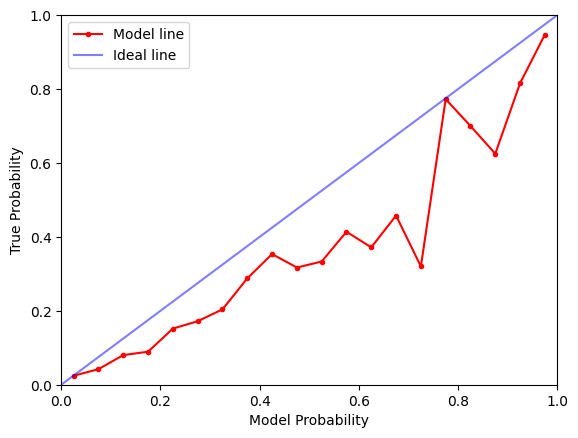

In [23]:
plot_probs = np.linspace(0,1.01, num = 10)

plt.plot(model_probs, true_probs, color = "red", marker='.', label = "Model line")
plt.plot(plot_probs, plot_probs, alpha = 0.5, color = "blue", label = "Ideal line")
plt.xlim(0,1)
plt.ylim(0,1)
#plt.axvspan(0.9, 1, alpha=0.1, label = "No shots with prob > 0.9", color = "red")
plt.legend()
plt.xlabel("Model Probability")
plt.ylabel("True Probability")
plt.show()

## Isometric regression

In [ ]:
f_X = football_df.drop("shot_outcome_encoded", axis = 1)
f_y = football_df["shot_outcome_encoded"]

In [25]:
# setting a seed
seed = 123

random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

# splitting the data
f_train_x, f_test_x , f_train_y, f_test_y = train_test_split(
    f_X, f_y,
    test_size = 0.25,
    random_state= 123,
    shuffle = True
)

In [ ]:
# checking that both are the same
sum(f_test_y == test_y.numpy()) == len(test_y.numpy())

In [ ]:
# comparing statsbomb and our expected goal probabilities
test = pd.concat([f_test_x["shot_statsbomb_xg"].reset_index(), pd.DataFrame(pred_probs).reset_index()], axis = 1, ignore_index=True).drop([0,2], axis = 1)
test.columns = ["shot_statsbomb_xg", "pred_prob"]
test["diff"] = test["shot_statsbomb_xg"] - test["pred_prob"]

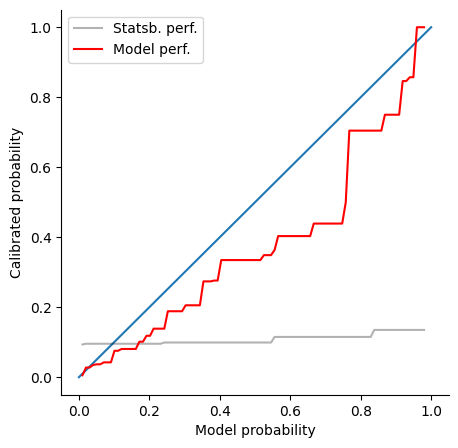

In [28]:
f_i_r = sk_i.IsotonicRegression().fit(test["shot_statsbomb_xg"], evaluation["outcome"])
i_r = sk_i.IsotonicRegression().fit(evaluation["pred_prob"], evaluation["outcome"])

model_probs = np.linspace(0, 1, num=100)

calibrated_probs = i_r.predict(model_probs)
f_calibrated_probs = f_i_r.predict(model_probs)

plt.figure(figsize=(5, 5))
plt.plot([0, 1], [0, 1])

plt.plot(model_probs, f_calibrated_probs, color='black', alpha = 0.3, label = "Statsb. perf.")
plt.plot(model_probs, calibrated_probs, color='red', label = "Model perf.")

plt.legend()

plt.xlabel('Model probability')
plt.ylabel('Calibrated probability')

sns.despine()

## AUC

In [ ]:
# Calculate AUC
auc = roc_auc_score(test_y, pred_probs)
print(f"AUC: {auc:.4f}")

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(test_y, pred_probs)

# Plot ROC curve
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {auc:.4f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

AUC: 0.4956


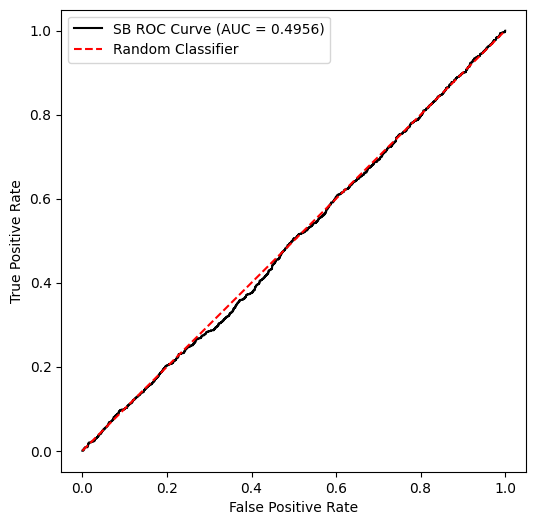

In [30]:
# Calculate AUC
auc = roc_auc_score(test_y, test["shot_statsbomb_xg"])
print(f"AUC: {auc:.4f}")

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(test_y, test["shot_statsbomb_xg"])

# Plot ROC curve
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='black', label=f'SB ROC Curve (AUC = {auc:.4f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()